In [1]:
import tensorflow.keras as keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
from tqdm import tqdm
from scipy.stats import multivariate_normal

(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()
y_train, y_test = y_train[:, 0], y_test[:, 0]

In [2]:
#random_indices = np.random.choice(range(len(y_train)), 10000, replace = False)
#X_train, y_train = X_train[random_indices], y_train[random_indices]
#indices_of_subclasses = np.where(y_train < 5)[0]
#X_train, y_train = X_train[indices_of_subclasses], y_train[indices_of_subclasses]

#random_indices = np.random.choice(range(len(y_test)), 1000, replace = False)
#X_train, y_train = X_train[random_indices], y_train[random_indices]
#random_indices = np.random.choice(range(len(y_test)), 500, replace = False)
#X_test, y_test = X_test[random_indices], y_test[random_indices]
#indices_of_subclasses = np.where(y_test < 5)[0]
#X_test, y_test = X_test[indices_of_subclasses], y_test[indices_of_subclasses]

In [200]:
'''
from keras.applications.resnet import ResNet50
encoder = ResNet50(include_top = False, input_shape = np.shape(X_train)[1:])
encoding_X_train = encoder.predict(X_train)[:, 0, 0, :]
encoding_X_test = encoder.predict(X_test)[:, 0, 0, :]
inp = keras.layers.Input(np.shape(encoding_X_train)[1:])

x = keras.layers.Dense(128, activation = 'relu')(inp)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(128, activation = 'relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(128, activation = 'relu')(x)
x = keras.layers.BatchNormalization()(x)
cls_logits = keras.layers.Dense(units=len(np.unique(y_train)), activation = 'linear')(x)
cls_out = keras.layers.Activation('softmax', name = 'cls_out')(cls_logits)

network = keras.models.Model(inputs = inp, outputs = cls_out)
network.compile(loss='categorical_crossentropy',
          optimizer=keras.optimizers.Adam(learning_rate=3e-4),
          metrics = ['acc'])
network.fit(encoding_X_train, keras.utils.to_categorical(y_train), 
    epochs = 25,
    verbose = 1,
    validation_split = .1)
'''
#load and train model 
inp = keras.layers.Input(np.shape(X_train)[1:])

x = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(inp)
x = keras.layers.MaxPooling2D()(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
x = keras.layers.MaxPooling2D()(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Flatten()(x)


x = keras.layers.Dense(units=1024, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(units=512, activation='relu')(x)
enc = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.2)(x)
cls_logits = keras.layers.Dense(units=len(np.unique(y_train)), activation = 'linear')(enc)
cls_out = keras.layers.Activation('softmax', name = 'cls_out')(cls_logits)

network = keras.models.Model(inputs = inp, outputs = cls_out)
encoder = keras.models.Model(inputs = inp, outputs = enc)
network.compile(loss='categorical_crossentropy',
          optimizer=keras.optimizers.Adam(learning_rate=3e-4),
          metrics = ['acc'])
network.fit(X_train, keras.utils.to_categorical(y_train), 
    epochs = 15,
    verbose = 1,
    validation_split = .1)

Epoch 1/15
1407/1407 [==============================] - 10s 6ms/step - loss: 1.5568 - acc: 0.4604 - val_loss: 1.2901 - val_acc: 0.5500
Epoch 2/15
1407/1407 [==============================] - 8s 6ms/step - loss: 1.1607 - acc: 0.5902 - val_loss: 1.0546 - val_acc: 0.6336
Epoch 3/15
1407/1407 [==============================] - 8s 6ms/step - loss: 0.9978 - acc: 0.6484 - val_loss: 0.9376 - val_acc: 0.6768
Epoch 4/15
1407/1407 [==============================] - 8s 6ms/step - loss: 0.8760 - acc: 0.6934 - val_loss: 0.9107 - val_acc: 0.6972
Epoch 5/15
1407/1407 [==============================] - 8s 6ms/step - loss: 0.7681 - acc: 0.7322 - val_loss: 0.8877 - val_acc: 0.7066
Epoch 6/15
1407/1407 [==============================] - 8s 6ms/step - loss: 0.6899 - acc: 0.7560 - val_loss: 0.7897 - val_acc: 0.7416
Epoch 7/15
1407/1407 [==============================] - 8s 6ms/step - loss: 0.6185 - acc: 0.7824 - val_loss: 0.8318 - val_acc: 0.7256
Epoch 8/15
1407/1407 [==============================] - 8s 6m

In [201]:
encoding_X_train = encoder.predict(X_train).reshape(X_train.shape[0], -1)
encoding_X_test = encoder.predict(X_test).reshape(X_test.shape[0], -1)

In [202]:
class_means, class_95, class_100, class_105 = [], [], [], []
for c in range(len(np.unique(y_train))):
    examples_of_class = np.where(y_train == c)[0]
    class_means.append(np.mean(encoding_X_train[examples_of_class], axis = 0))
    class_95.append(np.percentile(np.sqrt(np.sum(encoding_X_train[examples_of_class] ** 2, axis = 1)), 95))
    class_100.append(np.percentile(np.sqrt(np.sum(encoding_X_train[examples_of_class] ** 2, axis = 1)), 100))
    class_105.append(class_100[-1] + (class_100[-1] - class_95[-1]))

In [203]:
from scipy.stats import multivariate_normal as mv
vos_samples = []
for c in tqdm(range(len(np.unique(y_train)))):
    examples_of_class = np.where(y_train == c)[0]
    vos_samples_of_class = mv.rvs(mean = 0, cov = 1, size = (int(len(examples_of_class) / 3), np.shape(encoding_X_train)[1]))
    vos_samples_of_class = vos_samples_of_class / np.linalg.norm(vos_samples_of_class, axis =1)[:, np.newaxis]
    magnitudes = np.random.uniform(class_95[c], class_105[c], size = len(vos_samples_of_class))
    vos_samples_of_class = class_means[c] + vos_samples_of_class * class_105[c]#* magnitudes[:, np.newaxis]
    vos_samples.extend(vos_samples_of_class)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 14.26it/s]


In [204]:
ood_X_train = np.concatenate([encoding_X_train, vos_samples], axis = 0)
ood_y_train = np.concatenate([keras.utils.to_categorical(y_train), np.ones((len(vos_samples), len(np.unique(y_train)))) / len(np.unique(y_train))])

In [233]:
import tensorflow as tf
x = keras.layers.Dense(100, activation = 'relu')(enc)
#x = keras.layers.Dropout(0.5)(x)
x = keras.layers.BatchNormalization()(x)
pre_temperature = keras.layers.Dense(units = 1, activation = 'linear')(x)
#temperature = keras.layers.Lambda(lambda v : keras.activations.sigmoid(v) * 10)(pre_temperature)
#custom loss. We want the temperature to be unbounded on the positive side (and therefore when the pretemperature is greater than 0, it's unbounded; 
#but we also need to make sure the temperature is never negative - so we don't get infinite logits. So we do an exponentially decaying activation on the negative side)
temperature = keras.layers.Activation(lambda v : tf.where(v < 0, keras.activations.exponential(v), 1 + keras.activations.linear(v)))(pre_temperature)
ood_cls_logits = keras.layers.Lambda(lambda inputs: inputs[0] / inputs[1])([cls_logits, temperature])
ood_cls_out = keras.layers.Activation('softmax')(ood_cls_logits)

temperature_model = keras.models.Model(inputs = enc, outputs = temperature)
ood_network = keras.models.Model(inputs = enc, outputs = ood_cls_out)
for layer in network.layers:
    layer.trainable = False
ood_network.compile(loss='categorical_crossentropy',
          optimizer=keras.optimizers.Adam(learning_rate=3e-4))
ood_network.fit(ood_X_train, ood_y_train, 
    epochs = 30,
    verbose = 1,
    validation_split = .1)

Epoch 1/30
1875/1875 [==============================] - 7s 3ms/step - loss: 28.0701 - val_loss: 11.4367
Epoch 2/30
1875/1875 [==============================] - 6s 3ms/step - loss: 2.6400 - val_loss: 9.4665
Epoch 3/30
1875/1875 [==============================] - 6s 3ms/step - loss: 1.8463 - val_loss: 7.6562
Epoch 4/30
1875/1875 [==============================] - 6s 3ms/step - loss: 1.3976 - val_loss: 6.4000
Epoch 5/30
1875/1875 [==============================] - 6s 3ms/step - loss: 1.1441 - val_loss: 5.4389
Epoch 6/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.9735 - val_loss: 4.6555
Epoch 7/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.8325 - val_loss: 4.0788
Epoch 8/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.7422 - val_loss: 3.4799
Epoch 9/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.6926 - val_loss: 3.2775
Epoch 10/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.6

KeyboardInterrupt: 

In [234]:
t = temperature_model.predict(encoding_X_train)
print("In Distribution Temperature: ", np.mean(t))

In Distribution Temperature:  1.44436


In [235]:
t = temperature_model.predict(np.array(vos_samples))
print("OOD Temperature (we want this to be much higher than the in distribution temperature): ", np.mean(t))

OOD Temperature (we want this to be much higher than the in distribution temperature):  18.156837


In [236]:
pred = ood_network.predict(np.array(vos_samples))
print("Temperature Deflated OOD Confidence Average (we want this to be really low): ", np.mean(np.max(pred, axis = 1)))

Temperature Deflated OOD Confidence Average (we want this to be really low):  0.3315894


In [237]:
pred = ood_network.predict(encoding_X_train)
print("Temperature Deflated In-Distribution Confidence Average: ", np.mean(np.max(pred, axis = 1)))

Temperature Deflated In-Distribution Confidence Average:  0.8927313


In [238]:
pred = keras.models.Model(inputs = enc, outputs = cls_out).predict(np.array(vos_samples))
print("Unaffected Model OOD Confidence Average (this being high shows networks are overconfident OOD): ", np.mean(np.max(pred, axis = 1)))

Unaffected Model OOD Confidence Average (this being high shows networks are overconfident OOD):  0.918663


In [239]:
pred = network.predict(X_train)
print("Unaffected Model In-Distribution Confidence Average: ", np.mean(np.max(pred, axis = 1)))

Unaffected Model In-Distribution Confidence Average:  0.9479082


In [240]:
def get_ece(confidences, correctness):
    hists = []
    hists_hat = []
    amts = []
    num_bins = 100
    for i in range(num_bins):
        prop = i*1./num_bins
        inds = np.where((confidences >= prop) & (confidences <= prop+1./num_bins))[0]
        amts.append(len(inds))
        if len(inds) > 0:
            hists.append(len(np.where(correctness[inds] == 1)[0])*1./len(inds))
            hists_hat.append(np.mean(confidences[inds]))
        else:
            hists.append(prop)
            hists_hat.append(prop + 0.5/num_bins)
    return np.sum(np.abs(np.array(hists) - np.array(hists_hat)) * np.array(amts)) / np.sum(amts)

In [241]:
from sklearn.metrics import roc_auc_score, accuracy_score
pred = network.predict(X_test)

print(roc_auc_score(np.argmax(pred, axis = 1) == y_test, np.max(pred, axis = 1)))
class_eces = []
for j in range(len(np.unique(y_train))):
    class_eces.append(get_ece(np.array(pred)[:, j], y_test == j))
np.mean(class_eces)

0.8337373679084153


0.02842556630767591

In [242]:
pred = ood_network.predict(encoding_X_test)
print(roc_auc_score(np.argmax(pred, axis = 1) == y_test, np.max(pred, axis = 1)))
class_eces = []
for j in range(len(np.unique(y_train))):
    class_eces.append(get_ece(np.array(pred)[:, j], y_test == j))
np.mean(class_eces)

0.8334599177290059


0.018906922909779533

In [243]:
ood_scores_test = temperature_model.predict(encoding_X_test)[:, 0]

In [244]:
model_predictions = network.predict(X_test)
ood_model_predictions = ood_network.predict(encoding_X_test)

In [252]:
num_intervals = 5

In [253]:
#z_scores = p_label_error / (variance_confidences + 1e-12)
from sklearn.metrics import average_precision_score
order = np.argsort(ood_scores_test)[::-1]
ps = []
accs = []
base_eces = []
ood_model_eces = []

for i in range(0, len(y_test), int(len(y_test) / num_intervals)):
    class_eces = []
    for j in range(len(np.unique(y_train))):
        class_eces.append(get_ece(np.array(model_predictions)[order[i:i + int(len(y_test) / num_intervals)], j], (y_test[order[i:i + int(len(y_test) / num_intervals)]] == j)))
    base_eces.append(np.median(class_eces))

    class_eces = []
    for j in range(len(np.unique(y_train))):
        class_eces.append(get_ece(np.array(ood_model_predictions)[order[i:i + int(len(y_test) / num_intervals)], j], (y_test[order[i:i + int(len(y_test) / num_intervals)]] == j)))
    ood_model_eces.append(np.median(class_eces))

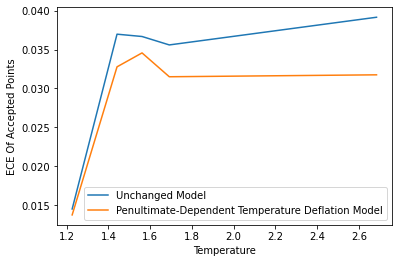

In [256]:
import matplotlib.pyplot as plt
plt.plot(ood_scores_test[order[np.arange(0, len(y_test), int(len(y_test) / num_intervals))]], base_eces, label = "Unchanged Model")
#plt.plot(np.arange(0, len(y_test), int(len(y_test) / num_intervals)) / len(y_test), base_eces, label = "Unchanged Model")
plt.plot(ood_scores_test[order[np.arange(0, len(y_test), int(len(y_test) / num_intervals))]], ood_model_eces, label = "Penultimate-Dependent Temperature Deflation Model")
#plt.plot(np.arange(0, len(y_test), int(len(y_test) / num_intervals)) / len(y_test), ood_model_eces, label = "Penultimate-Dependent Temperature Deflation Model")
plt.xlabel("Temperature")
plt.ylabel("ECE Of Accepted Points")
plt.legend()

The blue line increasing shows that when temperature i
The orange line being lower shows that this penultimate-dependent temperature lowers ECE, which is potentially lowered even further by training to uniform confidence on the Virtual Outliers